<a href="https://colab.research.google.com/github/joseortiz87/corning-innova-service/blob/main/Avance2_9Equipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract opencv-python
!pip install PyMuPDF pillow

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 92.2 MB/s eta 0:00:00


 Total 11 recuadros únicos
 Tupla # dígitos por Campo {1: 1, 2: 2, 3: 2, 4: 2, 5: 1, 6: 2, 7: 1, 8: 1, 9: 1, 10: 3, 11: 1}


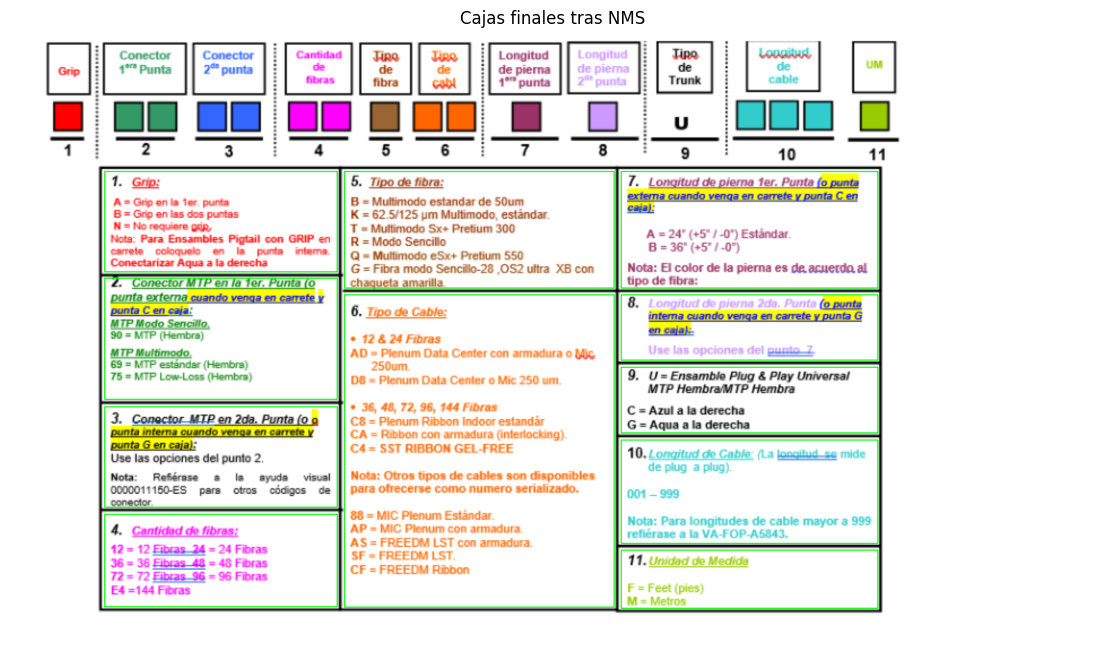

In [ ]:
import cv2
import fitz
from PIL import Image
import numpy as np
import pytesseract
import json
from matplotlib import pyplot as plt

def load_image(filename):
    """Loads an image from a file, handling both images and PDFs."""
    file_type = filename.split('.')[-1].lower()

    if file_type in ['jpg', 'jpeg', 'png', 'gif']:
        image = cv2.imread(filename)
    else:  # Assume PDF
        doc = fitz.open(filename)
        page = doc.load_page(0)
        pix = page.get_pixmap()
        img_pil = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        image = np.array(img_pil)
        image = image[:, :, ::-1].copy()

    image = cv2.resize(image, None, fx=3, fy=3, interpolation=cv2.INTER_LINEAR)

    return image

def extract_text_boxes(image, min_size=150):
    """Extracts text boxes from an image using contour detection and adaptive thresholding."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    inv = cv2.bitwise_not(gray)
    thresh = cv2.adaptiveThreshold(inv, 255,
                                  cv2.ADAPTIVE_THRESH_MEAN_C,
                                  cv2.THRESH_BINARY, 15, -10)

    contours, _ = cv2.findContours(thresh,
                               cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_SIMPLE)
    raw_sub_boxes = []

    for (x, y, w, h) in (cv2.boundingRect(c) for c in contours):
        if w < min_size or h < min_size:
            continue

        roi = image[y:y+h, x:x+w]
        sub_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        sub_thresh = cv2.adaptiveThreshold(sub_gray, 255,
                                          cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY, 15, 0)
        sub_cnts, _ = cv2.findContours(sub_thresh,
                                      cv2.RETR_TREE,
                                      cv2.CHAIN_APPROX_SIMPLE)
        for (sx, sy, sw, sh) in (cv2.boundingRect(sc) for sc in sub_cnts):
            if sw < min_size or sh < min_size or sw >= w or sh >= h:
                continue
            sub_roi = roi[sy:sy+sh, sx:sx+sw]  # Region from sub_cnts
            sub_sub_gray = cv2.cvtColor(sub_roi, cv2.COLOR_BGR2GRAY)
            inv = cv2.bitwise_not(sub_sub_gray)
            sub_sub_thresh = cv2.adaptiveThreshold(inv, 255,
                                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                                  cv2.THRESH_BINARY, 15, 7)
            sub_sub_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
            sub_sub_closed = cv2.morphologyEx(sub_sub_thresh, cv2.MORPH_CLOSE, sub_sub_kernel)
            sub_sub_cnts, _ = cv2.findContours(sub_sub_closed,
                                              cv2.RETR_TREE,
                                              cv2.CHAIN_APPROX_SIMPLE)

            for (ssx, ssy, ssw, ssh) in (cv2.boundingRect(ssc) for ssc in sub_sub_cnts):
                if ssw < min_size or ssh < min_size or ssw >= sw or ssh >= sh:
                    continue
                raw_sub_boxes.append([x + sx + ssx, y + sy + ssy, ssw, ssh])

    return raw_sub_boxes

def perform_ocr(image, boxes, config=r'--oem 3 --psm 6'):
    """Performs OCR on the given boxes and returns the results."""
    seen_texts = set()
    results = []

    for (x, y, w, h) in boxes:
        padding = 2
        x_pad = max(x - padding, 0)
        y_pad = max(y - padding, 0)
        ex_pad = min(x + w + padding, image.shape[1])
        ey_pad = min(y + h + padding, image.shape[0])

        sub_roi = image[y_pad: ey_pad, x_pad: ex_pad]
        text = pytesseract.image_to_string(sub_roi, config=config)
        text = text.replace('\x0c', '').strip()
        key = " ".join(text.split())

        if not key or key in seen_texts:
            continue

        seen_texts.add(key)
        results.append({
            "bbox": {"x": int(x), "y": int(y), "w": int(w), "h": int(h)},
            "text": key
        })

    return results

def obtain_final_boxes(image, raw_boxes):
    """Obtains the resume fields from the given raw boxes."""
    final_boxes = []
    if raw_boxes:
        scores = [1.0] * len(raw_boxes)
        keep_idxs = cv2.dnn.NMSBoxes(raw_boxes,
                                    scores,
                                    score_threshold=0.5,
                                    nms_threshold=0.3)
        # extraer cajas finales
        for i in keep_idxs:
            idx = i[0] if isinstance(i, (list,tuple,np.ndarray)) else i
            final_boxes.append(raw_boxes[idx])

    # Display boxes on the image and display it
    output = image.copy()
    for (x, y, w, h) in final_boxes:
        cv2.rectangle(output, (x, y), (x+w, y+h), (0,255,0), 2)
    plt.figure(figsize=(14,10))
    plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Cajas finales tras NMS")

    return final_boxes

def detect_color_rectangles(image):
    """Detects color rectangles and creates a codificator dictionary."""
    resized_image = cv2.resize(image, None, fx=3, fy=3, interpolation=cv2.INTER_LINEAR)
    hsv = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)

    lower_color = np.array([0, 1, 0])
    upper_color = np.array([255, 255, 255])
    mask = cv2.inRange(hsv, lower_color, upper_color)

    # Display processed image
    #plt.figure(figsize=(12, 6))
    #plt.imshow(mask, cmap='gray')
    #plt.title("Enhanced for OCR")
    #plt.axis('off')
    #plt.show()

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    output = resized_image.copy()
    squares = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if 200 < w < 300 and 200 < h < 300:  # Simplified size check
            cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 5)
            squares.append((x, y, w, h))

    codificator = create_codificator(squares)

    # Display detected squares
    #plt.figure(figsize=(15, 8))
    #plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    #plt.title("Recuadros detectados")
    #plt.axis('off')
    #plt.show()

    return codificator

def create_codificator(squares):
    """Creates the codificator dictionary from detected squares."""
    squares.sort(key=lambda sq: sq[0])  # Sort squares by x-coordinate
    codificator = {}
    field = 1
    digit_number = 1
    tolerance = 80
    maximun_space = 400

    for i, (x, y, w, h) in enumerate(squares):
        if i > 0:
            prev_end_x = squares[i - 1][0] + squares[i - 1][2]  # Previous square end x
            if prev_end_x + tolerance >= x:
                digit_number += 1
            else:
                codificator[field] = digit_number
                digit_number = 1
                field += 1
                if prev_end_x + maximun_space < x:  # Check for larger gap
                    codificator[field] = digit_number
                    digit_number = 1
                    field += 1

        if i == len(squares) - 1:  # Last square
            codificator[field] = digit_number

    return codificator

def main(filename):
    """Main function to extract text boxes and perform OCR."""
    image = load_image(filename)
    raw_boxes = extract_text_boxes(image)
    final_boxes = obtain_final_boxes(image, raw_boxes)
    results = perform_ocr(image, final_boxes)
    print(f" Total {len(results)} recuadros únicos")

    codificator_result = detect_color_rectangles(image)
    print(f" Tupla # dígitos por Campo {codificator_result}")

    display_results = [{
        "digit_per_fields": codificator_result,
        "fields_values": results
    }]

    with open("resultado.json", "w", encoding="utf-8") as f:
        json.dump(display_results, f, ensure_ascii=False, indent=2)



main("prueb.pdf")



## 1. Pre‑procesamiento y OCR

En lugar de las transformaciones clásicas de *Feature Engineering* (binning, escalamiento, etc.), el foco de esta fase fue convertir imágenes PDF en texto utilizable mediante:

| Paso | Acción realizada | Propósito | Justificación |
|------|-----------------|-----------|---------------|
| **Redimensionado** (`fx=3, fy=3`) | Aumentar resolución efectiva | Mejorar exactitud del OCR | Tesseract reduce errores con DPI ≥ 300 |
| **Conversión a escala de grises** | Simplificar información cromática | Facilitar umbralización | OCR requiere alto contraste |
| **Invertido de la imagen** | Fondos oscuros → claros | Resaltar recuadros y texto | Los contornos se detectan mejor sobre fondo claro |
| **Detección de contornos / sub‑contours** | Aislar cada bloque de texto | Permitir extracción puntual | Evita mezclar textos de distintos recuadros |
| **OCR con Tesseract** | Extraer texto crudo | Generar datos legibles por máquina | Paso fundamental para cualquier análisis posterior |
| **Limpieza de texto** (eliminar espacios duplicados, saltos de línea, caracteres basura) | Normalizar resultados | Facilitar parsing posterior | Mejora la calidad semántica |

---

## 2. Estructuración y exportación a JSON

Para que los resultados puedan consumirse por modelos o APIs downstream se construyó un **esquema JSON** con la siguiente lógica:

```jsonc
{
  "bounding_box": [x, y, w, h],   // Coordenadas absolutas
  "text": "texto limpio extraído",
  "page": 1
}


## Conclusión de la fase de “Preparación de los datos” (CRISP‑ML)

- **Transformación exitosa**: las páginas PDF se convirtieron en un corpus **JSON** estructurado, limpio y trazable, preservando la posición de cada bloque de texto.  
- **Calidad mejorada**: el pre‑procesamiento (redimensionado, inversión, detección de contornos y limpieza de texto) redujo los errores de OCR y normalizó la información entre páginas y recuadros.  
- **Interoperabilidad garantizada**: el esquema JSON permite cargar el dataset directamente en pipelines de ML, dashboards o microservicios sin pasos adicionales.  
- **Trazabilidad y reproducibilidad**: todos los parámetros y decisiones quedaron documentados en el cuaderno, cumpliendo con los requisitos de *Data Lineage* de CRISP‑ML.  
- **Listos para modelar**: con los datos estructurados y validados, se da por concluida la fase de Preparación, habilitando la transición a la fase de **Modelado**.
